# Code stuff - not slides!

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

# Session 14:
## Supervised learning, part 3

*Andreas Bjerre-Nielsen*

## Agenda
1. [decision trees](#Decision-trees)
1. [ensemble learning](#Ensemble-learning)
1. machine learning for social scientists
    - [direct applications of machine learning](#Direct-applications-of-machine-learning)
    - [prediction policy problems](#Prediction-policy-problems)
    - [machine learning in model estimation](#Machine-learning-in-model-estimation)

## Vaaaamos

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

plt.style.use('default') # set style (colors, background, size, gridlines etc.)
plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots
plt.rcParams.update({'font.size': 18})

## It sucks not being able to complete all the exercises...

- We know, we feel sorry, we have been there. The exercises help you grow. 

> #### Hadley Wickham

> The bad news is that when ever you learn a new skill you’re going to suck. It’s going to be frustrating. The good news is that is typical and happens to everyone and it is only temporary. You can’t go from knowing nothing to becoming an expert without going through a period of great frustration and great suckiness.

> #### Kosuke Imai

> One can learn data analysis only by doing, not by reading.

## With great power ...

### comes great responsibility...

You have been suffering a lot with implementing estimators... why?

- If you don't know what is going on you are likely to apply erroneously.
- So very important although you don't use in the exam.

# Decision trees

## A hierarchal structure 
*What does a decision tree look like?*



<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch03/images/03_17.png' alt="Drawing" style="width: 700px;"/></center>


## Sample splitting (1)
*Suppose we have data like below, we are interested in predicting criminal*

In [12]:
df = pd.DataFrame({'Criminal':[1]*5+[0]*10,
                   'From Jutland':np.random.randint(0,2,15),                   
                   'Parents together':[0]*4+[1]*10+[0],
                   'Parents unemployed':[1]*7+[0]*8})

print(df.sample(n=5))


    Criminal  From Jutland  Parents together  Parents unemployed
3          1             0                 0                   1
1          1             0                 0                   1
14         0             0                 0                   0
7          0             0                 1                   0
6          0             1                 1                   1


## Sample splitting (2)
*Let's try to split by 'From Jutland' together and see whether it helps*

In [17]:
my_split = df\
            .groupby(['From Jutland'])\
            .Criminal\
            .value_counts()\
            .unstack(level=-1)\

print(my_split)

Criminal      0  1
From Jutland      
0             6  3
1             4  2


## Sample splitting (3)
*Let's try to split by number parents together and see whether it helps*

In [15]:
my_split = df\
.groupby(['Parents together'])\
.Criminal\
.value_counts()\
.unstack(level=-1)\

print(my_split)

Criminal          0  1
Parents together      
0                 1  4
1                 9  1


## Sample splitting (4)
*What if we also split by 'Parents unemployed'? And From Jutland?*

In [18]:
my_split = df\
.groupby(['Parents together', 
          'Parents unemployed','From Jutland'])\
.Criminal\
.value_counts()\
.unstack(level=-1)\
.fillna(0)

print(my_split)

Criminal                                            0    1
Parents together Parents unemployed From Jutland          
0                0                  0             1.0  0.0
                 1                  0             0.0  2.0
                                    1             0.0  2.0
1                0                  0             5.0  0.0
                                    1             2.0  0.0
                 1                  0             0.0  1.0
                                    1             2.0  0.0


## Sample splitting (5)
*What might a tree structure look like?*

- Parents together: Yes > Not criminal    
<br/><br/>        
- Parents together: No
    - Parents unemployed: Yes > Criminal
    - Parents unemployed: No > Not criminal        

## Sample splitting (6)
*Suppose we have the Iris data, how would you split it?*

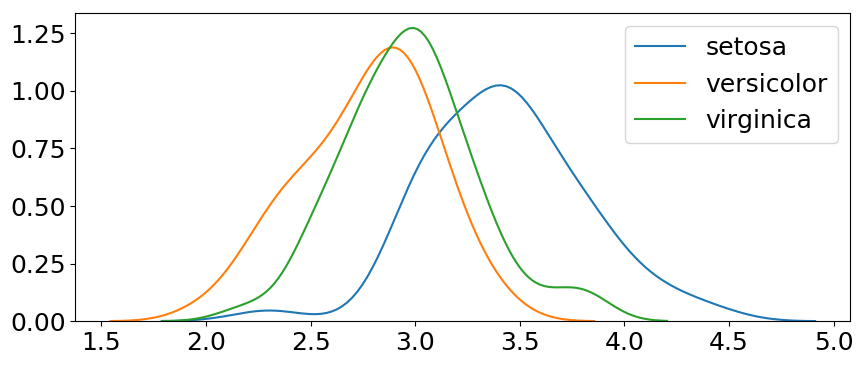

In [7]:
iris = sns.load_dataset('iris')
for species, species_df in iris.groupby('species'):
    sns.kdeplot(species_df.sepal_width,label=species)

## Decision Tree Classification (1)
*Let's try automatic sample splitting*

Find all splits in features
- Split is always binary (above, below)
    - Works for integers and float too  
- Compute the likelihood p of above for each class conditional on split

Take split which maximizes  Shannon Entropy (or Gini):
    $$-\sum_{i}p_i\log_2p_i$$
    
 


## Decision Tree Classification (2)
*So how deep can this go?*

- Very deep, as deep as we want. Depth is a hyperparameter (many others).

*So what are some disadvantages?*

- The trees are not easy to interpret.
- Non-linear, jumpy effects.

## Decision Tree Classification (3)
*Does the tool exist in sklearn?*

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

## Decision Tree Classification (4)
*What does our tree look like?*


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch03/images/03_21.png' alt="Drawing" style="width: 500px;"/></center>


## Decision Tree Classification (5)
*What does the decision boundaries look like?*

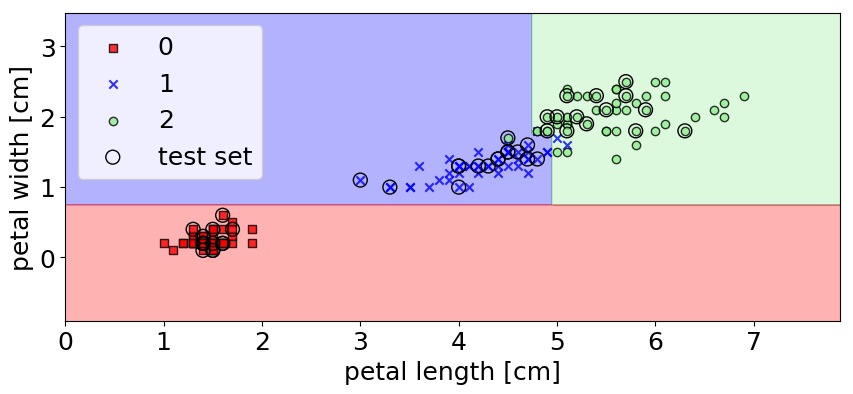

In [9]:
plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

## Evaluating decision trees
*What can we conclude about the decision trees?*

- Can fit anything ~ Universal Approximation
    - *little* underfitting (~low bias)
    - **LARGE** overfitting (~large variance)

# Universal approximation

## Universal approximators (1)
*Are decision trees the only universal approximators?*

No there are others.

- K Nearest Neighbors:
    - Approximate by taking average/mode from K nearest neighbors
        - Need standardization
    - Can also be used for interpolated local measures (weather, prices etc.)
    - Not good with high dimensionality.

   
- Neural networks (deep learning)

## Universal approximators (2)
*I have forgotten, what was Adaline?*


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch12/images/12_01.png' alt="Drawing" style="width: 700px;"/></center>


## Universal approximators (3)
*Why are neural networks called deep learning?*


<center><img src='https://github.com/rasbt/python-machine-learning-book-2nd-edition/raw/master/code/ch12/images/12_02.png' alt="Drawing" style="width: 700px;"/></center>


## Universal approximators (4)
*So learning about the Perceptron and Adaline actually has value?*

Yes, lot's of value. Think of these tools as building blocks for building a neural network.

# Random forest

## The wisdom of the crowd (1)

What can we do to reduce overfitting of a decision tree?

- We create multiple trees where for each tree
    - We draw a subsample of observation
    - We draw a subsample of features
    
These combined decision trees are called a random forest.
- The predicted value is the mode (most common) predicted by the trees
- Extension to regression where the mean over trees is computed.
- Works almost like magic out of the box.

## The wisdom of the crowd (2)

This process of taking the mode or mean is more general and called **bootstrap aggregation** or **bagging*.

The idea of combining different models into one is called **ensemble learning**.

# Direct applications of machine learning

## Direct applications of ML  (1): testing predictive power

ML helps us with making predictive models: 

- Assess the performance of our models
- Choose the parameters that help estimate the best performing model 

Can we use ML to help us clarify whether a new feature set is relevant for prediction?

## Direct applications of ML (2): new data

Machine learning can help us *'fill in the blanks'* and impute missing data

Input: Google Street View
- Infer neighborhood socioeconomic status (Naik, Raskar, Hidalgo 2016)

Input: Cell phone data
- Inferring poverty. (Blumenstock, Cadamuro, On 2015)
- Inferring mode of transportation. (Bjerre-Nielsen et al. 2018)
- Sleep (Cuttone et al. 2017)

Facebook data can help infer
- personality and demographics (Cambridge Analytica); socioeconomic status; current mood

## Direct applications of ML (3): better policy targetting

Social and medical scientists are often involved in policies aimed at: 
- alleviating poverty, decrease drop-out, crime etc.

Efficacy of these programs requires targetting of individuals:
- who is most poor, who is most at risk of dropping out? dying?

Kleinberg et al. 2015 show that mortality from surgery can be predicted in advance.
- save billions of $ and not cause pain of surgery


## ML in estimation

Many econometric methods try to establish causality:

- e.g. use of instrument variables (2SLS), matching 
- both of these problems have a prediction problem built-in
    - can be enhanced with machine learning

Machine learning can also be used to find heterogenous and non-linear effects

Just as an estimator.. Rasmus Bjørn

# Outro 

There are amazing resources for you to keep learning, online and offline.

@ in Denmark.
- Center for Social Data Science
  - [Topics SDS course](github.com/abjer/tsds): spatial data, more text, networks - some new stuff
  - Seminar in econometrics and machine learning 
  - A new education
- Jeppe Druedahl's [numeric economics course](https://github.com/JeppeDruedahl/NumEcon) using Python
- More courses are taught in machine learning at DTU


@ online.
- MIT open courseware, coursera, edX, etc.

# Everyone freeze!

### Please run the course evaluation now (5 min)

- Evaluate our actions: 
  - What was good, what was not good

- Please evaluate: 
  - our teaching: did I make myself clear? was I too fast? what about Snorre?
  - the material (exercises, books)
  - peer grading
  - machine learning curriculum

# The end
[Return to agenda](#Agenda)